In [2]:
!pip install keras 

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.1 MB 2.7 MB/s eta 0:00:01
  Using cached optree-0.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (311 kB)
     |████████████████████████████████| 2.2 MB 62.5 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 54.0 MB/s eta 0:00:01
  Using cached h5py-3.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.3 MB)
  Using cached rich-13.7.1-py3-none-any.whl (240 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
You should consider upgrading via the '/sysapps/ubuntu-applications/python/venv/pytorch/bin/python3 -m pip install --upgrade pip' command.


In [1]:
!pip install tensorflow 

Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.16.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
  Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Using cached grpcio-1.64.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.6 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.5.4-py3-none-any.whl (19 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached tensorflow_io_gcs_filesystem-0.37.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.1 MB)
  Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Using cached protobuf-4.25.3-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Using cached ml_dtypes-0.3.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2

In [6]:
!pip install dateparser


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 294 kB 2.7 MB/s eta 0:00:01
You should consider upgrading via the '/sysapps/ubuntu-applications/python/venv/pytorch/bin/python3 -m pip install --upgrade pip' command.


/home/users/kkodamagulla1/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


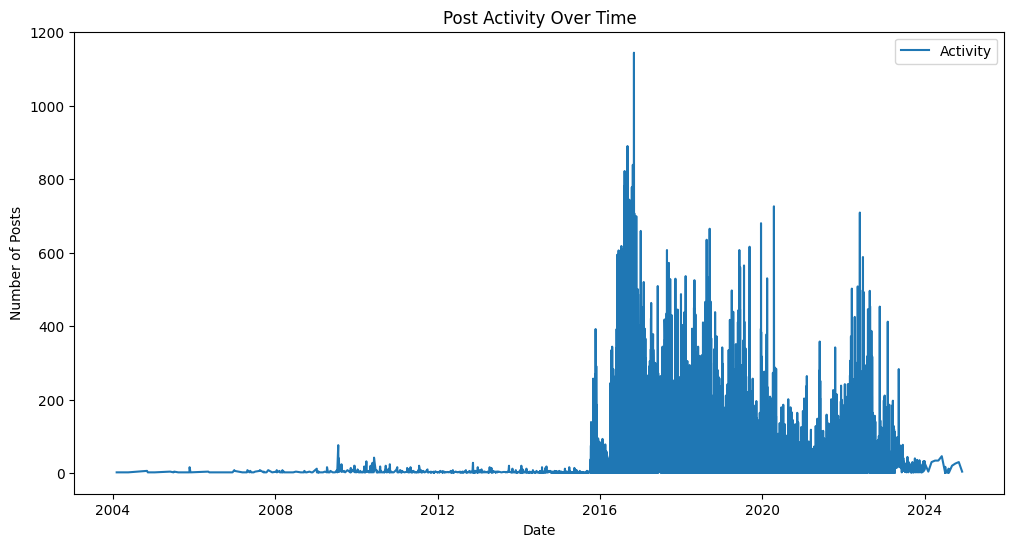

Epoch [10/100], Loss: 0.0057
Epoch [20/100], Loss: 0.0057
Epoch [30/100], Loss: 0.0056
Epoch [40/100], Loss: 0.0056
Epoch [50/100], Loss: 0.0055
Epoch [60/100], Loss: 0.0054
Epoch [70/100], Loss: 0.0053
Epoch [80/100], Loss: 0.0051
Epoch [90/100], Loss: 0.0051
Epoch [100/100], Loss: 0.0050
Training MSE: 6588.4873
Test MSE: 3140.7722
Training MAE: 40.8681
Test MAE: 30.5050


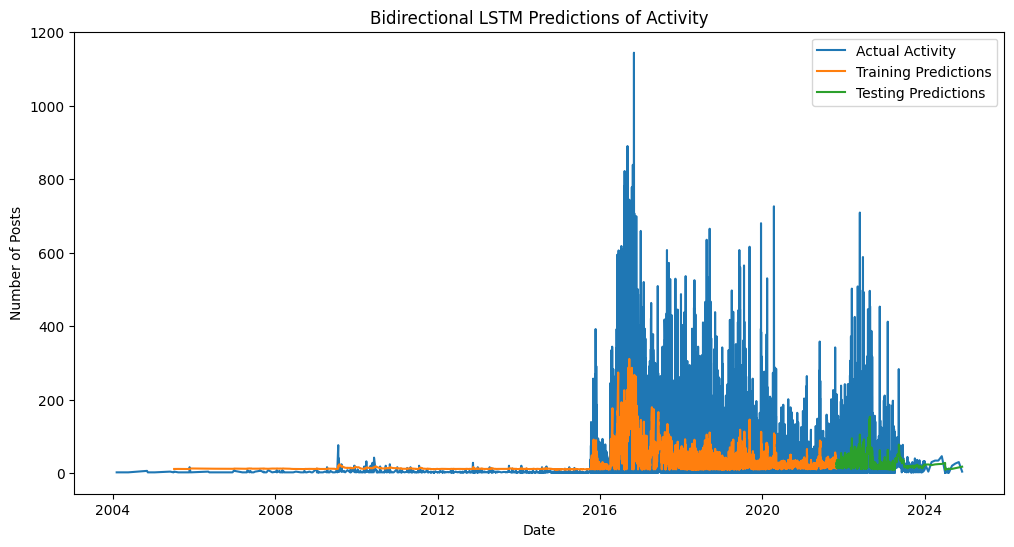

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
import dateparser

# Load the data
df = pd.read_csv('Fraud_final_merged.csv')

# Convert 'Post_date' to datetime
df['Post_date'] = df['Post_date'].apply(lambda x: dateparser.parse(str(x)))

# Aggregate post counts by date
activity_counts = df['Post_date'].value_counts().sort_index()
activity_df = activity_counts.reset_index()
activity_df.columns = ['Post_date', 'Count']

# Plotting the activity over time
plt.figure(figsize=(12, 6))
plt.plot(activity_df['Post_date'], activity_df['Count'], label='Activity')
plt.title('Post Activity Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.show()

# Function to create dataset for time series prediction
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Preparing data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(activity_df['Count'].values.reshape(-1, 1))

# Creating the training and testing datasets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, time_step, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, time_step, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Bidirectional LSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # 2 for bidirectional

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1
num_epochs = 100
learning_rate = 0.001

model_bi_lstm = BiLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_bi_lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    model_bi_lstm.train()
    outputs = model_bi_lstm(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model_bi_lstm.eval()
train_predict_bi = model_bi_lstm(X_train).detach().numpy()
test_predict_bi = model_bi_lstm(X_test).detach().numpy()

# Transform back to original scale
train_predict_bi = scaler.inverse_transform(train_predict_bi)
test_predict_bi = scaler.inverse_transform(test_predict_bi)
y_train_actual = scaler.inverse_transform(y_train.numpy())
y_test_actual = scaler.inverse_transform(y_test.numpy())

# Creating date indices for predictions
train_predict_dates = activity_df['Post_date'].iloc[time_step:len(train_predict_bi) + time_step]
test_predict_dates = activity_df['Post_date'].iloc[train_size + time_step:]

# Ensure the lengths match
train_predict_dates = train_predict_dates[:len(train_predict_bi)]
test_predict_dates = test_predict_dates[:len(test_predict_bi)]

# Calculate evaluation metrics
train_mse = mean_squared_error(y_train_actual, train_predict_bi)
test_mse = mean_squared_error(y_test_actual, test_predict_bi)
train_mae = mean_absolute_error(y_train_actual, train_predict_bi)
test_mae = mean_absolute_error(y_test_actual, test_predict_bi)

print(f'Training MSE: {train_mse:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Training MAE: {train_mae:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Plot Bidirectional LSTM results
plt.figure(figsize=(12, 6))
plt.plot(activity_df['Post_date'], activity_df['Count'], label='Actual Activity')
plt.plot(train_predict_dates, train_predict_bi, label='Training Predictions')
plt.plot(test_predict_dates, test_predict_bi, label='Testing Predictions')
plt.title('Bidirectional LSTM Predictions of Activity')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.show()


Epoch [10/100], Loss: 0.0059
Epoch [20/100], Loss: 0.0055
Epoch [30/100], Loss: 0.0051
Epoch [40/100], Loss: 0.0051
Epoch [50/100], Loss: 0.0051
Epoch [60/100], Loss: 0.0051
Epoch [70/100], Loss: 0.0050
Epoch [80/100], Loss: 0.0050
Epoch [90/100], Loss: 0.0050
Epoch [100/100], Loss: 0.0050


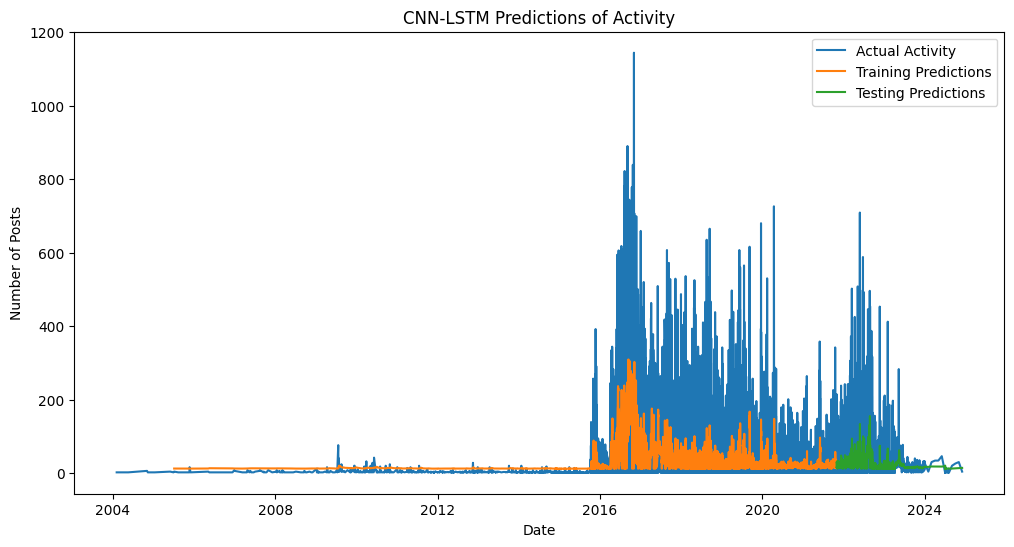

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn

# Assuming 'activity_df', 'time_step', 'train_size', 'X_train', 'y_train', 'X_test', 'y_test', and 'scaler' have been defined as in previous parts of the code

# CNN-LSTM hybrid model
class CNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CNNLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.transpose(1, 2)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Hyperparameters
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1
num_epochs = 100
learning_rate = 0.001

model_cnn_lstm = CNNLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cnn_lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    model_cnn_lstm.train()
    outputs = model_cnn_lstm(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model_cnn_lstm.eval()
train_predict_cnn = model_cnn_lstm(X_train).detach().numpy()
test_predict_cnn = model_cnn_lstm(X_test).detach().numpy()

# Transform back to original scale
train_predict_cnn = scaler.inverse_transform(train_predict_cnn)
test_predict_cnn = scaler.inverse_transform(test_predict_cnn)

# Creating date indices for predictions
train_predict_dates_cnn = activity_df['Post_date'].iloc[time_step:len(train_predict_cnn) + time_step]
test_predict_dates_cnn = activity_df['Post_date'].iloc[train_size + time_step:]

# Ensure the lengths match
train_predict_dates_cnn = train_predict_dates_cnn[:len(train_predict_cnn)]
test_predict_dates_cnn = test_predict_dates_cnn[:len(test_predict_cnn)]

# Plot CNN-LSTM results
plt.figure(figsize=(12, 6))
plt.plot(activity_df['Post_date'], activity_df['Count'], label='Actual Activity')
plt.plot(train_predict_dates_cnn, train_predict_cnn, label='Training Predictions')
plt.plot(test_predict_dates_cnn, test_predict_cnn, label='Testing Predictions')
plt.title('CNN-LSTM Predictions of Activity')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.show()


Epoch [1/50], Loss: 0.4830
Epoch [2/50], Loss: 0.2403
Epoch [3/50], Loss: 0.1620
Epoch [4/50], Loss: 0.1354
Epoch [5/50], Loss: 0.1235
Epoch [6/50], Loss: 0.1187
Epoch [7/50], Loss: 0.1171
Epoch [8/50], Loss: 0.1162
Epoch [9/50], Loss: 0.1155
Epoch [10/50], Loss: 0.1153
Epoch [11/50], Loss: 0.1144
Epoch [12/50], Loss: 0.1150
Epoch [13/50], Loss: 0.1149
Epoch [14/50], Loss: 0.1140
Epoch [15/50], Loss: 0.1140
Epoch [16/50], Loss: 0.1143
Epoch [17/50], Loss: 0.1138
Epoch [18/50], Loss: 0.1138
Epoch [19/50], Loss: 0.1129
Epoch [20/50], Loss: 0.1135
Epoch [21/50], Loss: 0.1131
Epoch [22/50], Loss: 0.1125
Epoch [23/50], Loss: 0.1126
Epoch [24/50], Loss: 0.1120
Epoch [25/50], Loss: 0.1123
Epoch [26/50], Loss: 0.1123
Epoch [27/50], Loss: 0.1126
Epoch [28/50], Loss: 0.1119
Epoch [29/50], Loss: 0.1126
Epoch [30/50], Loss: 0.1123
Epoch [31/50], Loss: 0.1118
Epoch [32/50], Loss: 0.1120
Epoch [33/50], Loss: 0.1122
Epoch [34/50], Loss: 0.1120
Epoch [35/50], Loss: 0.1121
Epoch [36/50], Loss: 0.1122
E

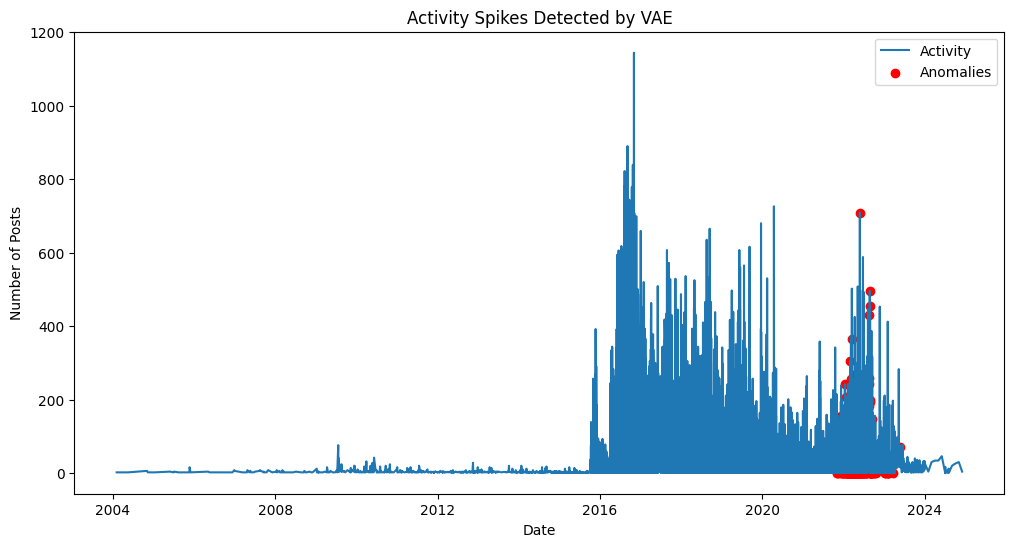

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from transformers import BertTokenizer, BertModel

# Assuming 'activity_df', 'time_step', 'train_data', 'test_data', 'learning_rate' have been defined as in previous parts of the code

# Variational Autoencoder (VAE) for anomaly detection
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Initialize VAE model
input_dim = train_data.shape[1]
hidden_dim = 64
latent_dim = 2
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Convert data to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)

# Train VAE model
num_epochs = 50
batch_size = 256
vae.train()
for epoch in range(num_epochs):
    train_loss = 0
    for i in range(0, len(train_data_tensor), batch_size):
        batch = train_data_tensor[i:i + batch_size]
        recon_batch, mu, logvar = vae(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_data_tensor):.4f}')

# Evaluate VAE model on test data
vae.eval()
reconstructions, _, _ = vae(test_data_tensor)
mse = np.mean(np.power(test_data_tensor.detach().numpy() - reconstructions.detach().numpy(), 2), axis=1)

# Print Mean Squared Error on test data
print(f'Test MSE: {mse.mean():.4f}')

# Threshold for anomalies
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

# Plot anomalies detected by VAE
anomaly_dates = activity_df['Post_date'][train_size + time_step:train_size + len(test_data_tensor)]
anomaly_counts = activity_df['Count'][train_size + time_step:train_size + len(test_data_tensor)]
anomalies = anomalies[:len(anomaly_dates)]  # Ensure lengths match

plt.figure(figsize=(12, 6))
plt.plot(activity_df['Post_date'], activity_df['Count'], label='Activity')
plt.scatter(anomaly_dates[anomalies], anomaly_counts[anomalies], color='red', label='Anomalies')
plt.title('Activity Spikes Detected by VAE')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm

# Load the data
df = pd.read_csv('Fraud_final_merged1.csv')

# Handle NaN values in 'Post Content' by replacing them with an empty string
df['Post Content'] = df['Post_content'].fillna('')

# Ensure 'Post Content' is of string type
df['Post Content'] = df['Post_content'].astype(str)

# BERT embeddings for post content
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')
model_bert.eval()  # Set the model to evaluation mode

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bert.to(device)

def get_bert_embeddings_batch(texts, tokenizer, model, max_length=512):
    encoded_input = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    encoded_input = {key: tensor.to(device) for key, tensor in encoded_input.items()}
    with torch.no_grad():
        output = model(**encoded_input)
    return output.last_hidden_state.mean(dim=1).cpu().numpy()

# Process in batches
batch_size = 32
embeddings = []
for i in tqdm(range(0, len(df), batch_size)):
    batch_texts = df['Post_content'].iloc[i:i + batch_size].tolist()
    batch_embeddings = get_bert_embeddings_batch(batch_texts, tokenizer, model_bert)
    embeddings.extend(batch_embeddings)

df['BERT_Embeddings'] = embeddings

# Example of using BERT embeddings for further analysis
print(df['BERT_Embeddings'].head())

# Save BERT embeddings for future use
df.to_csv('data_with_bert_embeddings.csv', index=False)




/home/users/kkodamagulla1/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 4289/4289 [27:44<00:00,  2.58it/s]


0    [-0.44063336, 0.05069214, 0.13429478, -0.43765...
1    [-0.40814975, 0.051823553, 0.13134485, -0.4546...
2    [-0.48096246, -0.025905661, 0.10914424, -0.404...
3    [-0.00048062578, -0.117914274, 0.196402, 0.069...
4    [0.04988931, -0.27219802, 0.5174166, -0.037034...
Name: BERT_Embeddings, dtype: object
